In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
from time import time
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

# enable 16 bit precision for jax                                                                                                                             
from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
from jax import jit, grad, random

import numpyro
import numpyro.distributions as dist
MultivariateNormal = dist.MultivariateNormal
from numpyro.distributions import Normal
import optax

# Import GSM                                                                                                                                                  
import sys
sys.path.append('../gsmvi//')
from gsm import GSM
from bbvi import ADVI, Scorenorm, Fishernorm
#####                                                                                                                                                         
from initializers import lbfgs_init

# sys.path.append('../utils/')
# from monitors import KLMonitor_Gauss as Monitor

import tensorflow_probability as tfp
SinhArcsinh = tfp.substrates.jax.distributions.SinhArcsinh
MultivariateNormal_tf = tfp.substrates.jax.distributions.MultivariateNormalFullCovariance


/mnt/home/cmodi/miniconda3/envs/jaxenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from gsmvi.monitors import KLMonitor as Monitor



# BAM, BAM_lr

In [5]:
from bam import BAM
from gsm import GSM
from pbam import PBAM, PBAM_fullcov
from gsmvi.monitors import KLMonitor
# from gsmvi.bam_lrproject import BAM_lrproject



In [6]:

##### Simple experiment for multivaraite Gaussian with dense covariance matrix
#####                                                                                                                                                         
def setup_model(D=10, rank=4):

    # setup a Gaussian target distribution                                                                                                                    
    mean = np.random.random(D)
    L = np.random.normal(size = D*rank).reshape(D, rank)
    cov = np.matmul(L, L.T) + np.diag(np.random.normal(1, 1, D)*1e-1+1)
    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    lp = jit(lambda x: jnp.sum(model.log_prob(x)))
    lp_g = jit(grad(lp, argnums=0))
    ref_samples = np.random.multivariate_normal(mean, cov, 10000)
    return model, mean, cov, lp, lp_g, ref_samples


In [135]:

D = 512
rank = 32
model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank)

lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))

batch_size = 8
niter = 1000
nprint = 5
regf = lambda x: 100/(1+x)


In [136]:
alg = BAM(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)

monitor = KLMonitor(batch_size=100, ref_samples=ref_samples, checkpoint=5)
monitor = None
meanfit, covfit = alg.fit(key,  batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, monitor=monitor)


Iteration 0 of 1000
Iteration 200 of 1000
Iteration 400 of 1000
Iteration 600 of 1000
Iteration 800 of 1000
Iteration 1000 of 1000


In [137]:
ranklr = rank
# alg2 = PBAM_fullcov(D, lp_vmap, lp_g_vmap)
# key = jax.random.PRNGKey(2)
# monitor2 = KLMonitor(batch_size=100, ref_samples=ref_samples, checkpoint=5)
# meanfit2, covfit2 = alg2.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, monitor=monitor, early_stop=False)


alg3 = PBAM(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)
regf = lambda x: 100/(1+x)
meanfit3, psi, llambda = alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint)
covfit3 = np.diag(psi) + llambda@llambda.T



Iteration 0 of 1000
Iteration 200 of 1000
Iteration 400 of 1000
Iteration 600 of 1000
Iteration 800 of 1000
Iteration 1000 of 1000


169


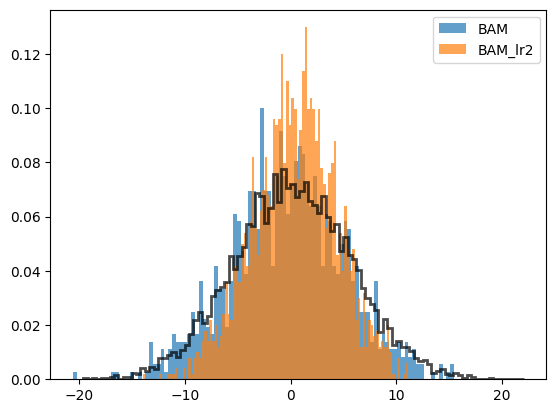

In [141]:
i = np.random.randint(D)
print(i)
plt.hist(np.random.multivariate_normal(meanfit, covfit, 1000)[..., i], bins=100, density=True, alpha=0.7, label='BAM');
# plt.hist(np.random.multivariate_normal(meanfit2, covfit2, 10000)[..., i], bins=100, density=True, alpha=0.7, label='BAM_lr');
# eps = np.random.normal(0, 1, (1000, D))
# z = np.random.normal(0, 1, (1000, ranklr))
# s3 = meanfit3 + psi*eps + (llambda@z.T).T
s3 = np.random.multivariate_normal(meanfit3, covfit3, 2000)
plt.hist(s3[..., i], bins=100, density=True, alpha=0.7, label='BAM_lr2');
plt.hist(ref_samples[..., i], bins=100, density=True, alpha=0.7, histtype='step', lw=2, color='k');
plt.legend()



[243  11 294 364 361]


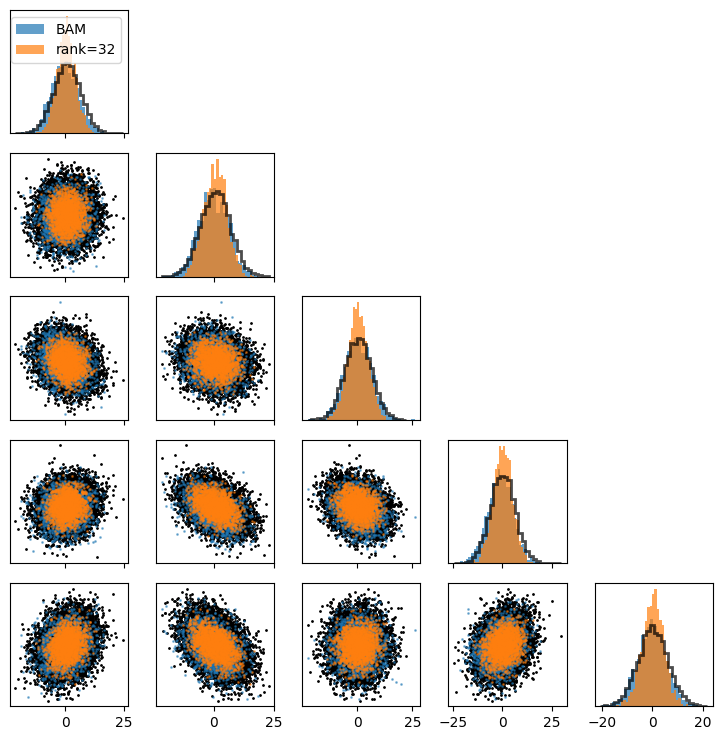

In [139]:
s = ref_samples[:, :] 
s1 = np.random.multivariate_normal(meanfit, covfit, 2000)
# s2 = np.random.multivariate_normal(meanfit2, covfit2, 2000)
s2 = None
s3 = np.random.multivariate_normal(meanfit3, covfit3, 2000)

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')
idx = np.random.permutation(np.arange(D))[:dplot]
print(idx)
for i in range(dplot):
    for j in range(dplot):
        ii, jj = idx[i], idx[j]
        if i == j: 
            ax[i, i].hist(s[..., ii], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2);
            ax[i, i].hist(s1[..., ii], alpha=0.7, density=True, bins=30, label=f"BAM");
            ax[i, i].hist(s3[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
            if s2 is not None: ax[i, i].hist(s2[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}-fullcov");
            
        elif j > i:
            ax[j, i].plot(s[..., ii], s[..., jj], '.', alpha=1., ms=2, color='k')
            ax[j, i].plot(s1[..., ii], s1[..., jj], '.', alpha=0.5, ms=2)
            ax[j, i].plot(s3[..., ii], s3[..., jj], '.', alpha=0.5, ms=2)
            if s2 is not None: ax[j, i].plot(s2[..., ii], s2[..., jj], '.', alpha=0.7, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()

# timings

## scaling with dims

In [88]:
ranklr = 8
batch_size = 2
niter = 20
nprint = -1
regf = lambda x: 100


tfull, tlr = [], []
dimsfull, dimslr = [], []
for i in range(3, 12):
    D = 2**i
    dimslr.append(D)
    print(D)
    model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank=8)
    lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
    lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))

    
    if D < 500:
        dimsfull.append(D)
        alg2 = PBAM_fullcov(D, lp_vmap, lp_g_vmap)
        key = jax.random.PRNGKey(2)
        alg2.fit(key, rank=ranklr, batch_size=batch_size, niter=2, regf=regf, nprint=nprint, monitor=None, early_stop=False, verbose=False)


    alg3 = PBAM(D, lp_vmap, lp_g_vmap)
    key = jax.random.PRNGKey(2)
    alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=2, regf=regf, nprint=nprint, verbose=False)
    

    if D < 500:
        start = time()
        alg2.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, monitor=None, early_stop=False, verbose=False)
        tfull.append(time()-start)

    start = time()
    alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, verbose=False)
    tlr.append(time()-start)

dimsfull = np.array(dimsfull )
dimslr = np.array(dimslr )
tfull = np.array(tfull)
tlr = np.array(tlr)



8
jit pbam update
jit psi/llambda update
16
jit pbam update
jit psi/llambda update
32
jit pbam update
jit psi/llambda update
64
jit pbam update
jit psi/llambda update
128
jit pbam update
jit psi/llambda update
256
jit pbam update
jit psi/llambda update
512
jit pbam update
jit psi/llambda update
1024
jit pbam update
jit psi/llambda update
2048
jit pbam update
jit psi/llambda update


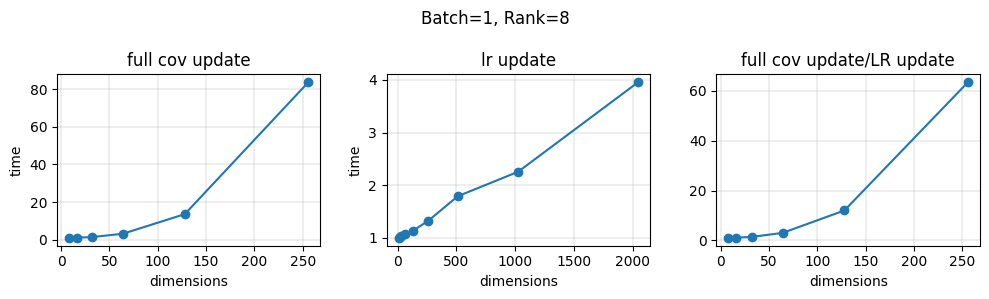

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

ax[0].plot(dimsfull, tfull/tfull[0], marker='o')
ax[0].set_title('full cov update')
ax[1].plot(dimslr, tlr/tlr[0], marker='o')
ax[1].set_title('lr update')
ax[2].plot(dimsfull, tfull/tfull[0]/tlr[:len(dimsfull)]*tlr[0], marker='o')
ax[2].set_title('full cov update/LR update')
for axis in ax[:2]: 
    # axis.loglog()
    axis.set_ylabel('time')
for axis in ax:
    axis.set_xlabel('dimensions')
    axis.grid(which='both', lw=0.3)
plt.suptitle(f'Batch={batch_size}, Rank={ranklr}')
plt.tight_layout()
 


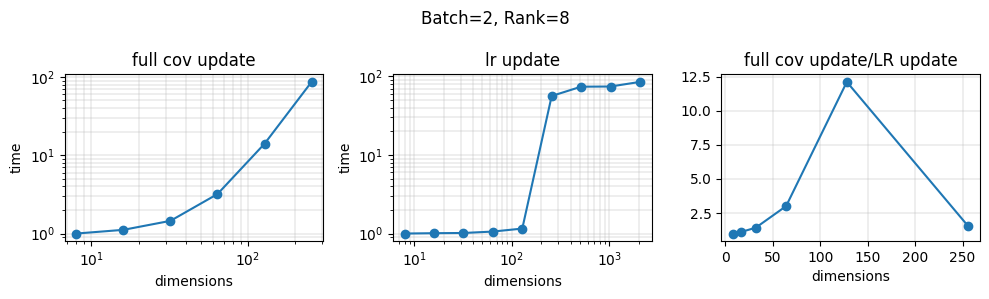

In [89]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

ax[0].plot(dimsfull, tfull/tfull[0], marker='o')
ax[0].set_title('full cov update')
ax[1].plot(dimslr, tlr/tlr[0], marker='o')
ax[1].set_title('lr update')
ax[2].plot(dimsfull, tfull/tfull[0]/tlr[:len(dimsfull)]*tlr[0], marker='o')
ax[2].set_title('full cov update/LR update')
for axis in ax[:2]: 
    axis.loglog()
    axis.set_ylabel('time')
for axis in ax:
    axis.set_xlabel('dimensions')
    axis.grid(which='both', lw=0.3)
plt.suptitle(f'Batch={batch_size}, Rank={rank}')
plt.tight_layout()
 


In [19]:
# rank = 8 
# ranklr = 4
# batch_size = 4
# niter = 20
# nprint = -1
# regf = lambda x: 100



# tlr = []
# dimslr = []
# for i in range(3, 12):
#     D = 2**i
#     dimslr.append(D)
#     print(D)
#     model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank=8)
#     lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
#     lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))


#     alg3 = PBAM(D, lp_vmap, lp_g_vmap)
#     key = jax.random.PRNGKey(2)
#     alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=5, regf=regf, nprint=nprint, verbose=False)
    
#     start = time()
#     alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, verbose=False)
#     tlr.append(time()-start)

# tlr = np.array(tlr)

8
jit psi/llambda update
16
jit psi/llambda update
32
jit psi/llambda update
64
jit psi/llambda update
128
jit psi/llambda update
256
jit psi/llambda update
512
jit psi/llambda update
1024
jit psi/llambda update
2048
jit psi/llambda update


In [37]:
# # plt.plot(dimslr, tlr/tlr[0], marker='o')
# plt.plot(dimslr, tlr, marker='o')
# plt.loglog()


## scaling with rank & batch

In [67]:
batch_size = 1
niter = 20
nprint = -1
regf = lambda x: 100

D = 512
model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank=256)
lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))

ranks = []
tranks = []

for i in range(1, 10):
    
    ranklr = 2**i
    print(ranklr)
    ranks.append(ranklr)
    alg3 = PBAM(D, lp_vmap, lp_g_vmap)
    key = jax.random.PRNGKey(2)
    alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=2, regf=regf, nprint=nprint, verbose=False)

    start = time()
    alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, verbose=False)
    tranks.append(time()-start)

ranks = np.array(ranks)
tranks = np.array(tranks)

2
jit pbam update
jit psi/llambda update
4
jit pbam update
jit psi/llambda update
8
jit pbam update
jit psi/llambda update
16
jit pbam update
jit psi/llambda update
32
jit pbam update
jit psi/llambda update
64
jit pbam update
jit psi/llambda update
128
jit pbam update
jit psi/llambda update
256
jit pbam update
jit psi/llambda update
512
jit pbam update
jit psi/llambda update


(0.01, 100.0)

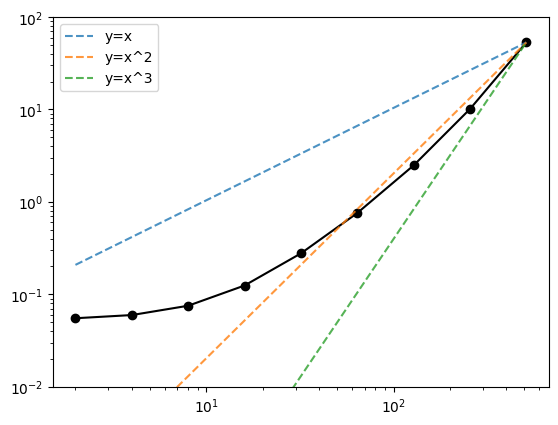

In [76]:
plt.plot(ranks, tranks, 'k', marker='o')
plt.plot(ranks, ranks/ranks[-1]*tranks[-1],  alpha=0.8, ls='--', label='y=x')
plt.plot(ranks, ranks**2/ranks[-1]**2*tranks[-1], alpha=0.8, ls='--', label='y=x^2')
plt.plot(ranks, ranks**3/ranks[-1]**3*tranks[-1],  alpha=0.8, ls='--', label='y=x^3')
plt.loglog()
plt.legend()
plt.ylim(1e-2, 1e2)

In [69]:
ranklr = 4
niter = 20
nprint = -1
regf = lambda x: 100


D = 512
model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank=256)
lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))

batches = []
tbatches = []

for i in range(1, 8):
    
    batch_size = 2**i
    print(batch_size)
    batches.append(batch_size)
    alg3 = PBAM(D, lp_vmap, lp_g_vmap)
    key = jax.random.PRNGKey(2)
    alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=2, regf=regf, nprint=nprint, verbose=False)

    start = time()
    alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, verbose=False)
    tbatches.append(time()-start)

batches = np.array(batches)
tbatches = np.array(tbatches)

2
jit pbam update
jit psi/llambda update
4
jit pbam update
jit psi/llambda update
8
jit pbam update
jit psi/llambda update
16
jit pbam update
jit psi/llambda update
32
jit pbam update
jit psi/llambda update
64
jit pbam update
jit psi/llambda update
128
jit pbam update
jit psi/llambda update


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


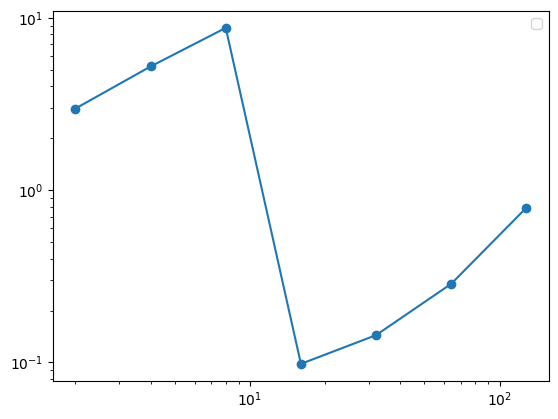

In [79]:
plt.plot(batches, tbatches, marker='o')
# plt.plot(batches, batches/batches[-1]*tbatches[0], color='k', alpha=0.8, ls='--', label='y=x')
# plt.plot(batches, batches**2/batches[0]**2*tbatches[0], color='k', alpha=0.8, ls='--', label='y=x^2')
# plt.plot(batches, batches**3/batches[0]**3*tbatches[0], color='k', alpha=0.8, ls='--', label='y=x^3')
plt.loglog()
plt.legend()